<center><h1>Chen_Shufen_HW4</h1></center>
<br>
<br>

Name: Shufen Chen
<br>
Github Username: shufench-usc
<br>
USC ID: 9180940635

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay,
)
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
import scipy.stats as stat
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.naive_bayes import GaussianNB, MultinomialNB

Get the AReM Data Set

In [2]:
# create a dictionary to store all the data folder names
folder_path_dic = {
    "bending1": 0,
    "bending2": 1,
    "cycling": 2,
    "lying": 3,
    "sitting": 4,
    "standing": 5,
    "walking": 6,
}


# get csv files from each floder
main_path = "../data/AReM/"
all_files = []

for path in folder_path_dic.keys():
    files = glob.glob(os.path.join(main_path, path, "*.csv"))
    all_files.append(files)

print(all_files)

[['../data/AReM/bending1/dataset7.csv', '../data/AReM/bending1/dataset6.csv', '../data/AReM/bending1/dataset4.csv', '../data/AReM/bending1/dataset5.csv', '../data/AReM/bending1/dataset1.csv', '../data/AReM/bending1/dataset2.csv', '../data/AReM/bending1/dataset3.csv'], ['../data/AReM/bending2/dataset6.csv', '../data/AReM/bending2/dataset4.csv', '../data/AReM/bending2/dataset5.csv', '../data/AReM/bending2/dataset1.csv', '../data/AReM/bending2/dataset2.csv', '../data/AReM/bending2/dataset3.csv'], ['../data/AReM/cycling/dataset7.csv', '../data/AReM/cycling/dataset6.csv', '../data/AReM/cycling/dataset4.csv', '../data/AReM/cycling/dataset5.csv', '../data/AReM/cycling/dataset1.csv', '../data/AReM/cycling/dataset2.csv', '../data/AReM/cycling/dataset3.csv', '../data/AReM/cycling/dataset10.csv', '../data/AReM/cycling/dataset11.csv', '../data/AReM/cycling/dataset13.csv', '../data/AReM/cycling/dataset12.csv', '../data/AReM/cycling/dataset15.csv', '../data/AReM/cycling/dataset14.csv', '../data/AReM

### (b) Splitting Data

I modifed this part of HW3 to support the label encoding and index resetting. The ‘bending' labels are added for binary classification, and the combination of file folder number and dataset number is used as the index, which is convenient for dataframe merging ans multi-class classification.

In [3]:
"""read csv files and combine them into test and train data sets"""

# create column names
column_names = [
    "time",
    "avg_rss12",
    "var_rss12",
    "avg_rss13",
    "var_rss13",
    "avg_rss23",
    "var_rss23",
]


# create empty lists to storn traiin data and test data
train_ls = []
test_ls = []

# split train and test data sets
for i in range(len(all_files)):
    for j in range(len(all_files[i])):
        f = folder_path_dic[
            all_files[i][j].split("/")[-2]
        ]  # get the combination of folder and dataset number, e.g. bending1/dataset1-->01
        d = re.search(
            r"(?:^|/)dataset(\d+)(?=\.csv$)", all_files[i][j]
        )  # extract the dataset number from file name
        if i < 2 and re.search(
            "dataset(1|2)(\D)", all_files[i][j]
        ):  # bending1 and bending2: dataset 1 and 2 (test data)
            df = pd.read_csv(
                all_files[i][j], names=column_names, skiprows=5, engine="python"
            )  # rename columns and skip first 5 rows (metadata)
            df["path"] = f"{f}{d.group(1)}"
            df["bending"] = 1
            test_ls.append(df)
        elif i < 2 and not re.search(
            "dataset(1|2)(\D)", all_files[i][j]
        ):  # rest datasts in bending1 and bending2 (train data)
            df = pd.read_csv(
                all_files[i][j],
                sep=",|\s",
                names=column_names,
                skiprows=5,
                engine="python",
            )
            df["path"] = f"{f}{d.group(1)}"
            df["bending"] = 1
            train_ls.append(df)
        elif i >= 2 and re.search(
            "dataset(1|2|3)(\D)", all_files[i][j]
        ):  # other folders: dataset 1, 2 and3 (test data)
            df = pd.read_csv(
                all_files[i][j], names=column_names, skiprows=5, engine="python"
            )
            df["path"] = f"{f}{d.group(1)}"
            df["bending"] = 0
            test_ls.append(df)
        else:  # other datasets (train data)
            df = pd.read_csv(
                all_files[i][j],
                sep=",|\s",
                names=column_names,
                skiprows=5,
                engine="python",
            )
            df["path"] = f"{f}{d.group(1)}"
            df["bending"] = 0
            train_ls.append(df)

# merge data frams into training and test data sets
train_df = pd.concat(train_ls, ignore_index=True)
test_df = pd.concat(test_ls, ignore_index=True)
total_df = pd.concat([train_df, test_df], ignore_index=True)  # merge the two data sets

# print and check the data sets
display(train_df)
display(test_df)
print(total_df.shape)

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,path,bending
0,0,42.00,0.00,18.50,0.50,12.00,0.00,07,1
1,250,42.00,0.00,18.00,0.00,11.33,0.94,07,1
2,500,42.75,0.43,16.75,1.79,18.25,0.43,07,1
3,750,42.50,0.50,16.75,0.83,19.00,1.22,07,1
4,1000,43.00,0.82,16.25,0.83,18.00,0.00,07,1
...,...,...,...,...,...,...,...,...,...
33114,118750,31.50,1.66,12.50,3.20,14.25,4.44,69,0
33115,119000,27.33,1.25,11.33,0.94,20.00,4.00,69,0
33116,119250,37.80,7.68,14.20,2.48,17.25,0.83,69,0
33117,119500,33.75,1.30,15.75,5.21,16.50,2.69,69,0


,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,path,bending
0,0,39.25,0.43,22.75,0.43,33.75,1.30,01,1
1,250,39.25,0.43,23.00,0.00,33.00,0.00,01,1
2,500,39.25,0.43,23.25,0.43,33.00,0.00,01,1
3,750,39.50,0.50,23.00,0.71,33.00,0.00,01,1
4,1000,39.50,0.50,24.00,0.00,33.00,0.00,01,1
...,...,...,...,...,...,...,...,...,...
9115,118750,36.00,2.45,17.00,5.10,20.50,0.87,63,0
9116,119000,34.33,1.89,15.00,2.45,17.00,2.12,63,0
9117,119250,33.00,7.35,14.60,3.14,13.00,5.70,63,0
9118,119500,31.67,1.25,11.00,6.16,19.25,2.17,63,0


(42239, 9)


### (c) Feature Extraction

I also modify the feature extraction function to support feature extraction for all the splited time series data.

In [4]:
def extract_features(
    data,
    time_series=[1, 2, 3, 4, 5, 6],
    stats_feature=["min", "max", "mean", "50%", "std", "25%", "75%"],
):
    """
    This function is for extracting time-domain features from time series data.

    parameters:
    data[dataframe]:dataset containing time series data
    time_series[list]:list of time series to extract features from, e.g. [1,2,3,4,5,6] for 6 time series
    stats_feature[list]:list of statistical features to extract

    returns:
    df_stats[dataframe]:dataframe containing extracted time-domain features
    """

    # create labels for time series, 6 time series per group, suffixed with group number(starting from 1, the fist group doesn't have suffixs)
    ts_original = [
        "avg_rss12",
        "var_rss12",
        "avg_rss13",
        "var_rss13",
        "avg_rss23",
        "var_rss23",
    ]
    ts_label = {}
    for i in time_series:
        group = (i - 1) // 6 + 1
        index = (i - 1) % 6

        if group == 1:
            ts_label[ts_original[index]] = index + 1
        else:
            ts_label[f"{ts_original[index]}_{group-1}"] = index + 1 + (group - 1) * 6

    # create labels for statistical features
    stats_label = {
        "min": "min",
        "max": "max",
        "mean": "mean",
        "50%": "median",
        "std": "standard deviation",
        "25%": "1st quart",
        "75%": "3rd quart",
    }

    ts_ls = []
    for i in time_series:
        for key, value in ts_label.items():
            if value == i:
                ts_ls.append(key)

    # rearrange the output's columns order
    stats_ls = [i for i in stats_feature]

    order = []
    for key, value in stats_label.items():
        for i in time_series:
            if key in stats_ls:
                order.append(f"{value}{i}")

    # get the time-domain features
    df_stats = (
        data.groupby(["path"])[ts_ls].describe().loc[:, pd.IndexSlice[ts_ls, stats_ls]]
    )
    df_stats.columns = [
        f"{stats_label[stat]}{ts_label[ts]}" for ts, stat in df_stats.columns
    ]
    df_stats = df_stats[order]

    return df_stats

In [5]:
# get the time-domain features
features_total = extract_features(total_df)
features_total.insert(0, "instance", range(1, len(features_total) + 1))
display(features_total.style.hide(axis="index"))

instance,min1,min2,min3,min4,min5,min6,max1,max2,max3,max4,max5,max6,mean1,mean2,mean3,mean4,mean5,mean6,median1,median2,median3,median4,median5,median6,standard deviation1,standard deviation2,standard deviation3,standard deviation4,standard deviation5,standard deviation6,1st quart1,1st quart2,1st quart3,1st quart4,1st quart5,1st quart6,3rd quart1,3rd quart2,3rd quart3,3rd quart4,3rd quart5,3rd quart6
1,37.250000,0.000000,4.000000,0.000000,27.250000,0.000000,45.000000,1.300000,29.500000,7.230000,38.250000,1.920000,40.624792,0.358604,19.040937,0.832542,34.311292,0.570583,40.500000,0.430000,19.250000,0.500000,35.000000,0.430000,1.476967,0.322605,4.462952,0.965659,2.188449,0.582915,39.250000,0.000000,16.000000,0.000000,33.000000,0.000000,42.000000,0.500000,23.250000,1.120000,36.000000,1.300000
2,38.000000,0.000000,2.000000,0.000000,27.670000,0.000000,45.670000,1.220000,29.500000,5.760000,38.500000,3.110000,42.812812,0.372437,20.096979,0.876438,33.024583,0.571083,42.500000,0.470000,21.000000,0.500000,33.000000,0.430000,1.435550,0.289158,3.893737,1.047259,1.995255,0.601010,42.000000,0.000000,19.000000,0.000000,32.000000,0.000000,43.670000,0.500000,22.250000,1.145000,34.500000,1.300000
3,35.000000,0.000000,6.500000,0.000000,29.000000,0.000000,47.400000,1.700000,29.750000,4.440000,38.500000,1.790000,43.954500,0.426250,22.122354,0.497312,35.588458,0.493292,44.330000,0.470000,23.000000,0.430000,36.000000,0.430000,1.558835,0.338690,3.030943,0.550657,1.999604,0.513506,43.000000,0.000000,19.750000,0.000000,35.362500,0.000000,45.000000,0.500000,24.000000,0.830000,36.500000,0.940000
4,33.000000,0.000000,8.500000,0.000000,20.000000,0.000000,47.750000,3.000000,30.000000,5.150000,38.670000,2.180000,42.179812,0.696042,22.183625,0.989917,33.493917,0.613521,43.500000,0.500000,23.000000,0.830000,35.000000,0.500000,3.670666,0.630860,3.810469,0.953730,3.849448,0.524317,39.150000,0.000000,20.500000,0.430000,30.457500,0.000000,45.000000,1.120000,24.372500,1.300000,36.330000,1.000000
5,33.000000,0.000000,3.000000,0.000000,23.670000,0.000000,45.750000,2.830000,28.250000,6.420000,37.500000,1.790000,41.678063,0.535979,19.006563,0.841875,29.857083,0.383292,41.750000,0.500000,19.125000,0.500000,30.000000,0.430000,2.243490,0.405469,4.087107,0.928801,2.411026,0.389164,41.330000,0.430000,16.500000,0.430000,28.457500,0.000000,42.750000,0.710000,22.062500,1.120000,31.250000,0.500000
6,37.000000,0.000000,5.750000,0.000000,8.000000,0.000000,48.000000,1.580000,27.000000,10.030000,33.500000,5.260000,43.454958,0.378083,15.793333,0.849354,23.034792,0.679646,43.250000,0.470000,15.000000,0.500000,23.500000,0.500000,1.386098,0.315566,3.847638,0.995761,2.488862,0.622534,42.500000,0.000000,13.000000,0.430000,22.250000,0.430000,45.000000,0.500000,18.270000,1.120000,24.000000,0.870000
7,36.250000,0.000000,1.500000,0.000000,11.330000,0.000000,48.000000,1.500000,26.330000,5.170000,30.750000,2.960000,43.969125,0.413125,15.868021,0.666354,22.103750,0.555312,44.500000,0.470000,16.250000,0.470000,21.670000,0.490000,1.618364,0.263111,3.742420,0.788985,3.318301,0.487826,43.310000,0.430000,14.250000,0.000000,20.500000,0.000000,44.670000,0.500000,18.000000,0.940000,23.750000,0.830000
8,12.750000,0.000000,0.000000,0.000000,10.670000,0.000000,51.000000,6.870000,25.330000,6.760000,30.000000,4.970000,24.562958,0.590833,19.121333,0.736771,23.493042,0.700188,24.250000,0.430000,20.250000,0.470000,23.750000,0.500000,3.737514,0.837408,4.299612,0.927048,3.693786,0.693720,23.187500,0.000000,18.000000,0.000000,20.500000,0.430000,26.500000,0.710000,22.000000,0.870000,27.000000,0.870000
9,0.000000,0.000000,7.500000,0.000000,0.000000,0.000000,42.750000,7.760000,35.000000,5.760000,33.000000,6.760000,27.464604,0.449708,20.842542,0.779917,17.617938,1.122125,28.000000,0.430000,20.750000,0.500000,18.000000,0.830000,3.583582,0.767197,3.826268,0.904436,5.053642,1.012342,25.500000,0.000000,18.000000,0.000000,15.000000,0.470000,30.000000,0.500000,22.500000,0.940000,20.750000,1.300000
10,21.000000,0.000000,0.

In [6]:
def estimate_std_ci(df):
    """
    This function estimates the standard deviation and 90% confidence interval for each time-domain feature using bootstrap method.

    Parameters:
        df (DataFrame): a dataframe containing the extracted features for each instance

    Returns:
        df_ci (DataFrame): a dataframe containing the standard deviation and 90% confidence interval for each time-domain feature
    """

    #  drop the "instance" column
    df = df.drop(columns="instance")

    # convert the dataframe to a numpy array and transpose it
    numpy_data = df.to_numpy().T

    # calculate the 90% confidence interval for the standard deviation using bootstrap method
    res = bootstrap((numpy_data,), np.std, confidence_level=0.9, axis=1, method="basic")

    std = np.std(
        numpy_data, axis=1, ddof=0
    )  # use population standard deviation (ddof=0)
    ci_low = res.confidence_interval.low
    ci_high = res.confidence_interval.high

    # create a dataframe to display the standard deviation and 90% confidence interval for each time-domain feature
    df_ci = pd.DataFrame(
        {
            "Time-domain feature": df.columns,
            "Standard Deviation": std,
            "90%CI_low": ci_low,
            "90%CI_high": ci_high,
        }
    )

    return df_ci

In [7]:
# estimate standard deviation of time-domain features without normalization
df_ci = estimate_std_ci(features_total)
display(df_ci)

,Time-domain feature,Standard Deviation,90%CI_low,90%CI_high
0,min1,9.515445,8.373461,10.825476
1,min2,0.000000,0.000000,0.000000
2,min3,2.939616,2.790196,3.136666
3,min4,0.000000,0.000000,0.000000
4,min5,6.089107,4.694667,7.801886
5,min6,0.045577,0.013125,0.091154
6,max1,4.369322,3.482342,5.427380
7,max2,5.033882,4.701909,5.471265
8,max3,4.847358,4.262294,5.551659
9,max4,2.171183,1.992967,2.380044


## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

The HW3 ask us to choose three most important features, I will modify my choice from median, IQR, and standard deviation to mean, median, and standard deviation since IQR is not included in the 7 time-domain features. Therefore, the plots here are about mean,median, and standard deviation.

In [8]:
# get the bending label from the total dataset and set path as the index
bending_label = total_df[["path", "bending"]].drop_duplicates()
bending_label = bending_label.set_index("path")

# extract three time-domain features(mean, median, standard deviation) from the training dataset
features_tr = extract_features(
    train_df, time_series=[1, 2, 6], stats_feature=["mean", "50%", "std"]
)

# get the index of training dataset, andsplit the bending label intotraining set and testing set
y_train = bending_label.loc[features_tr.index]
y_test = bending_label.drop(index=y_train.index)

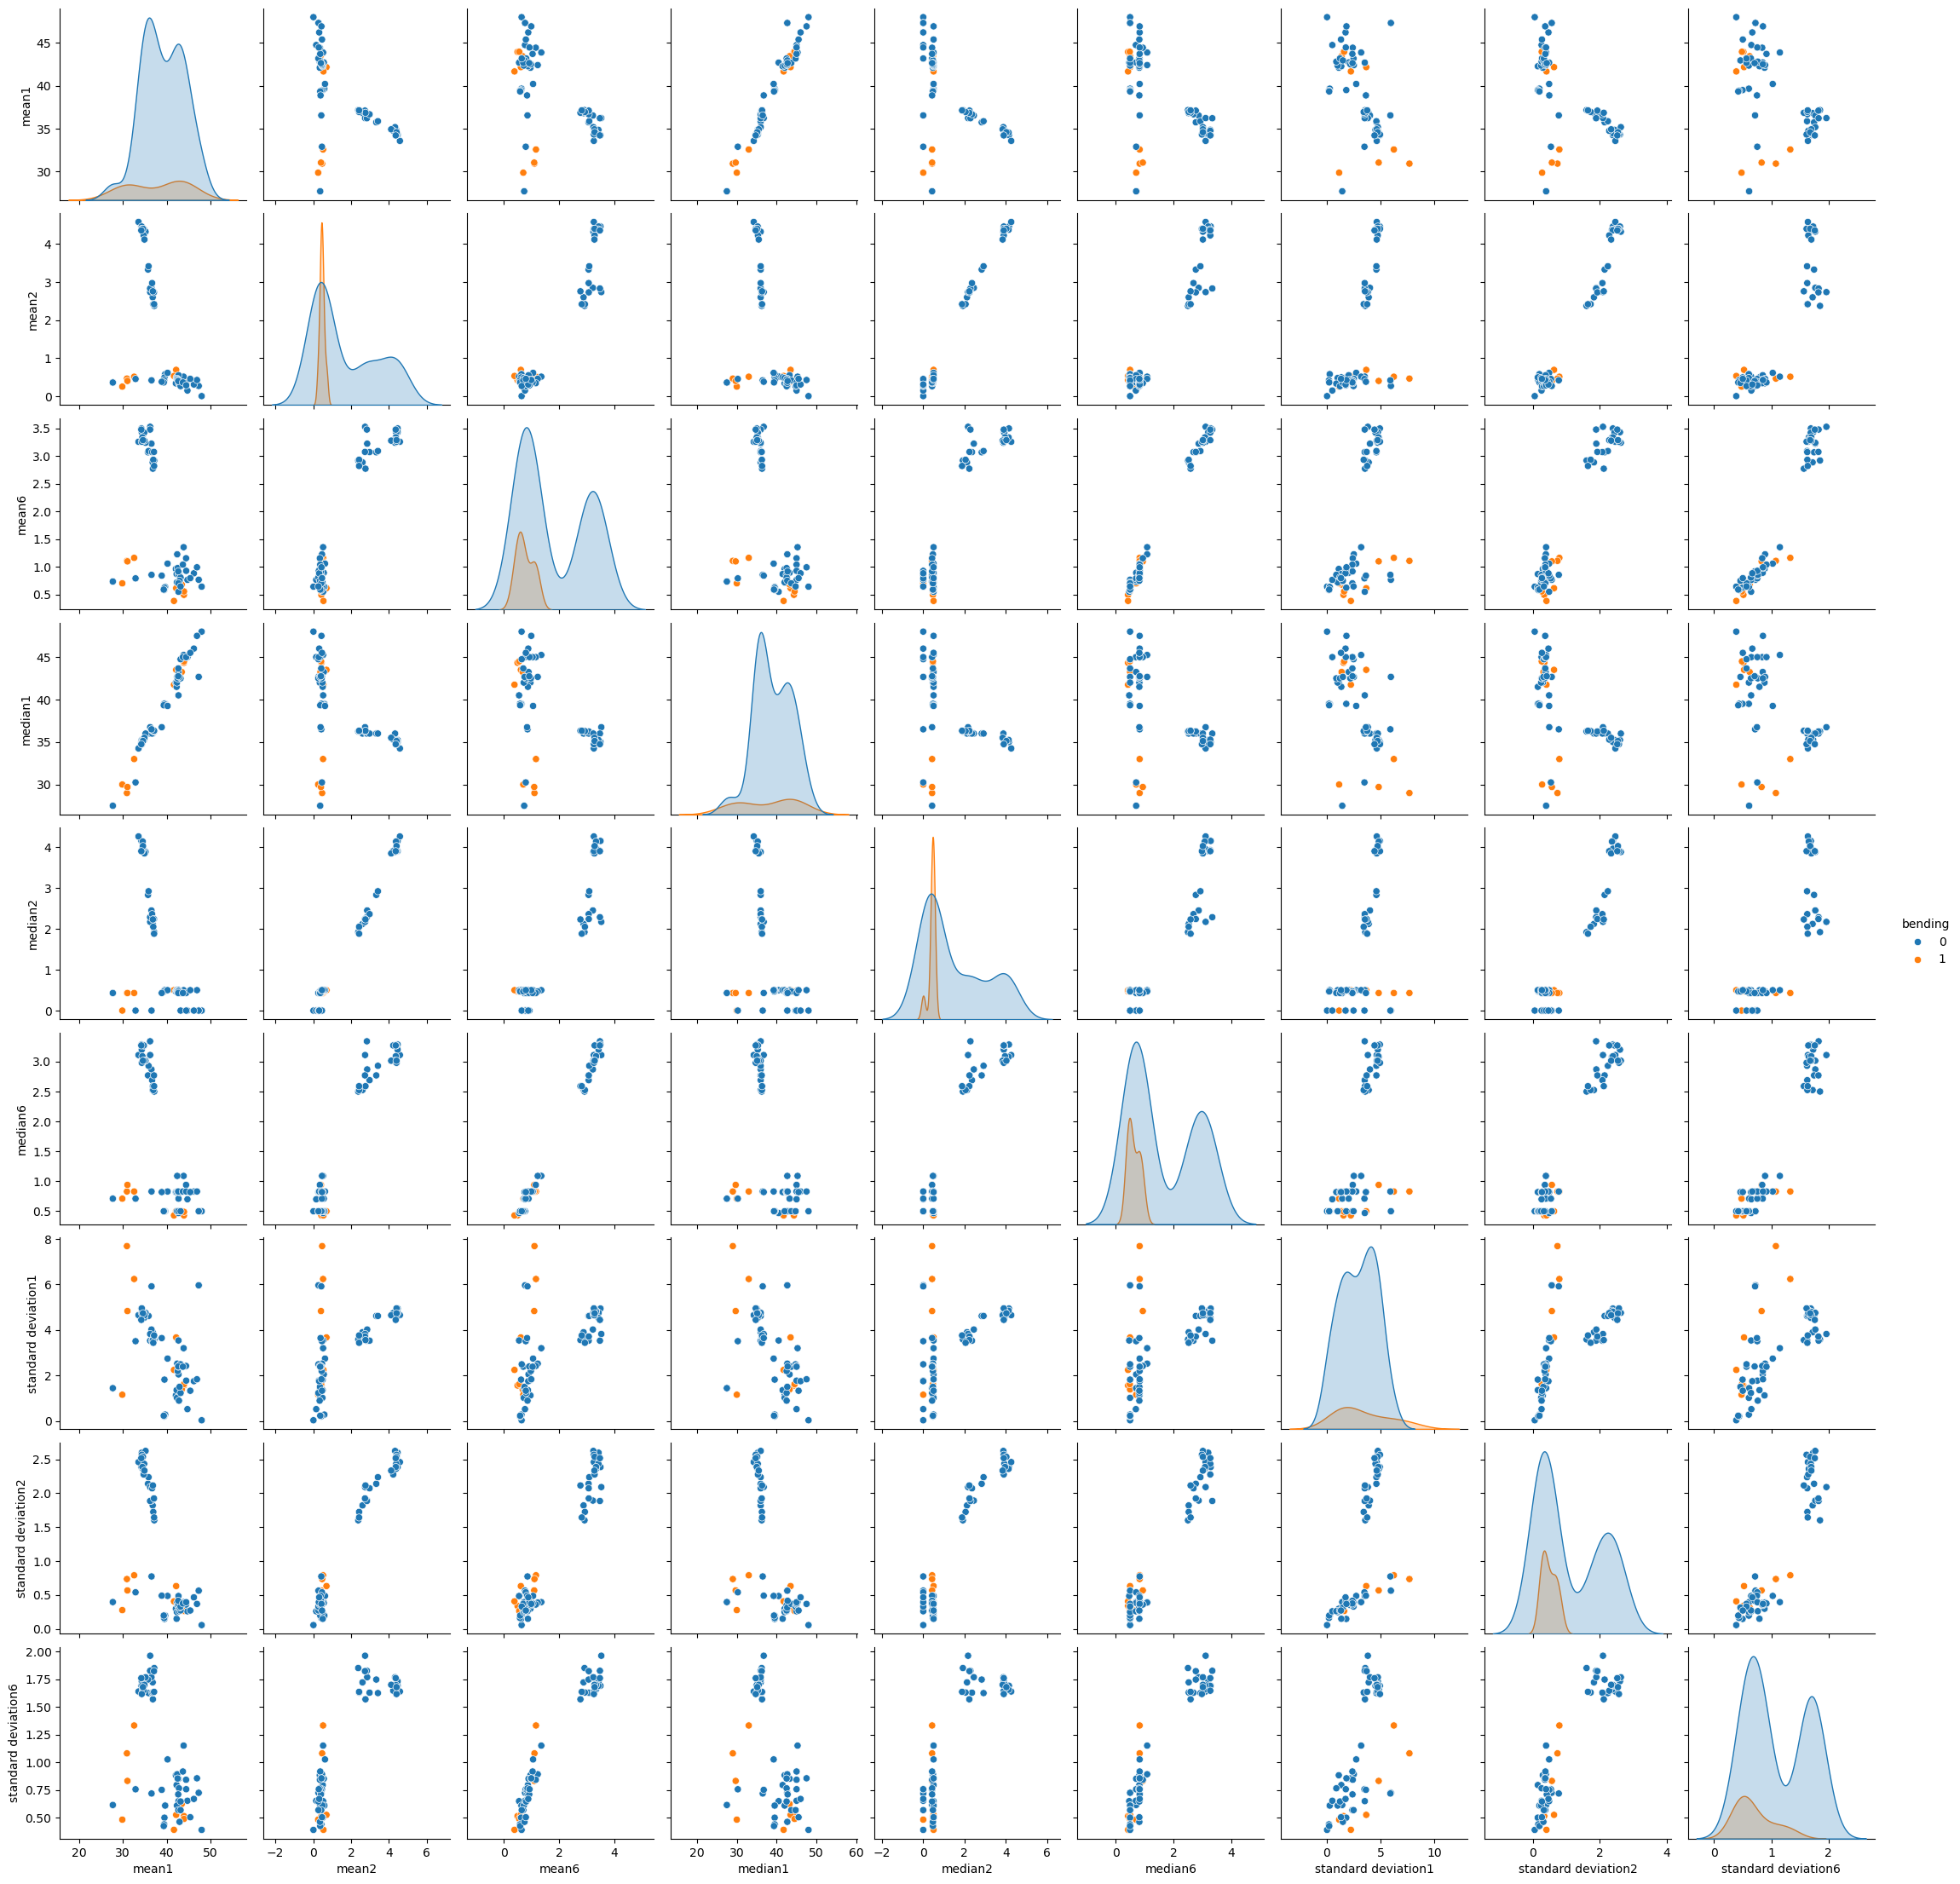

In [9]:
# add the bending column to the features_tr dataframe for plotting
f_tr_cols = features_tr.columns.to_list()
f_tr_cols.append('bending')

plot_df = features_tr.merge(y_train, left_index=True, right_index=True)[f_tr_cols]

sns.pairplot(plot_df, hue='bending')
plt.show()

#### ii. Splitted Plots

In [10]:
# split the training set into two time series
half_1 = train_df.groupby(["path"]).apply(lambda x: x.iloc[: len(x) // 2])
half_1 = half_1.reset_index(drop=True)
half_2 = train_df.groupby(["path"]).apply(lambda x: x.iloc[len(x) // 2 :])
half_2 = half_2.reset_index(drop=True)

# extract three time-domain features(mean, median, standard deviation) for the first half of the training set
features_h1 = extract_features(
    half_1, time_series=[1, 2, 6], stats_feature=["mean", "50%", "std"]
)

# extract three time-domain features(mean, median, standard deviation) for the second half of the training set and rename the columns
features_h2 = extract_features(
    half_2, time_series=[1, 2, 6], stats_feature=["mean", "50%", "std"]
)
features_h2.columns = [f"{name}_1" for name in features_h1.columns]

/var/folders/n2/qm35mwj17rxdqgtkgj7wbqmr0000gn/T/ipykernel_66008/2090501356.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  half_1 = train_df.groupby(["path"]).apply(lambda x: x.iloc[: len(x) // 2])
/var/folders/n2/qm35mwj17rxdqgtkgj7wbqmr0000gn/T/ipykernel_66008/2090501356.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  half_2 = train_df.groupby(["path"]).apply(lambda x: x.iloc[len(x) // 2 :])


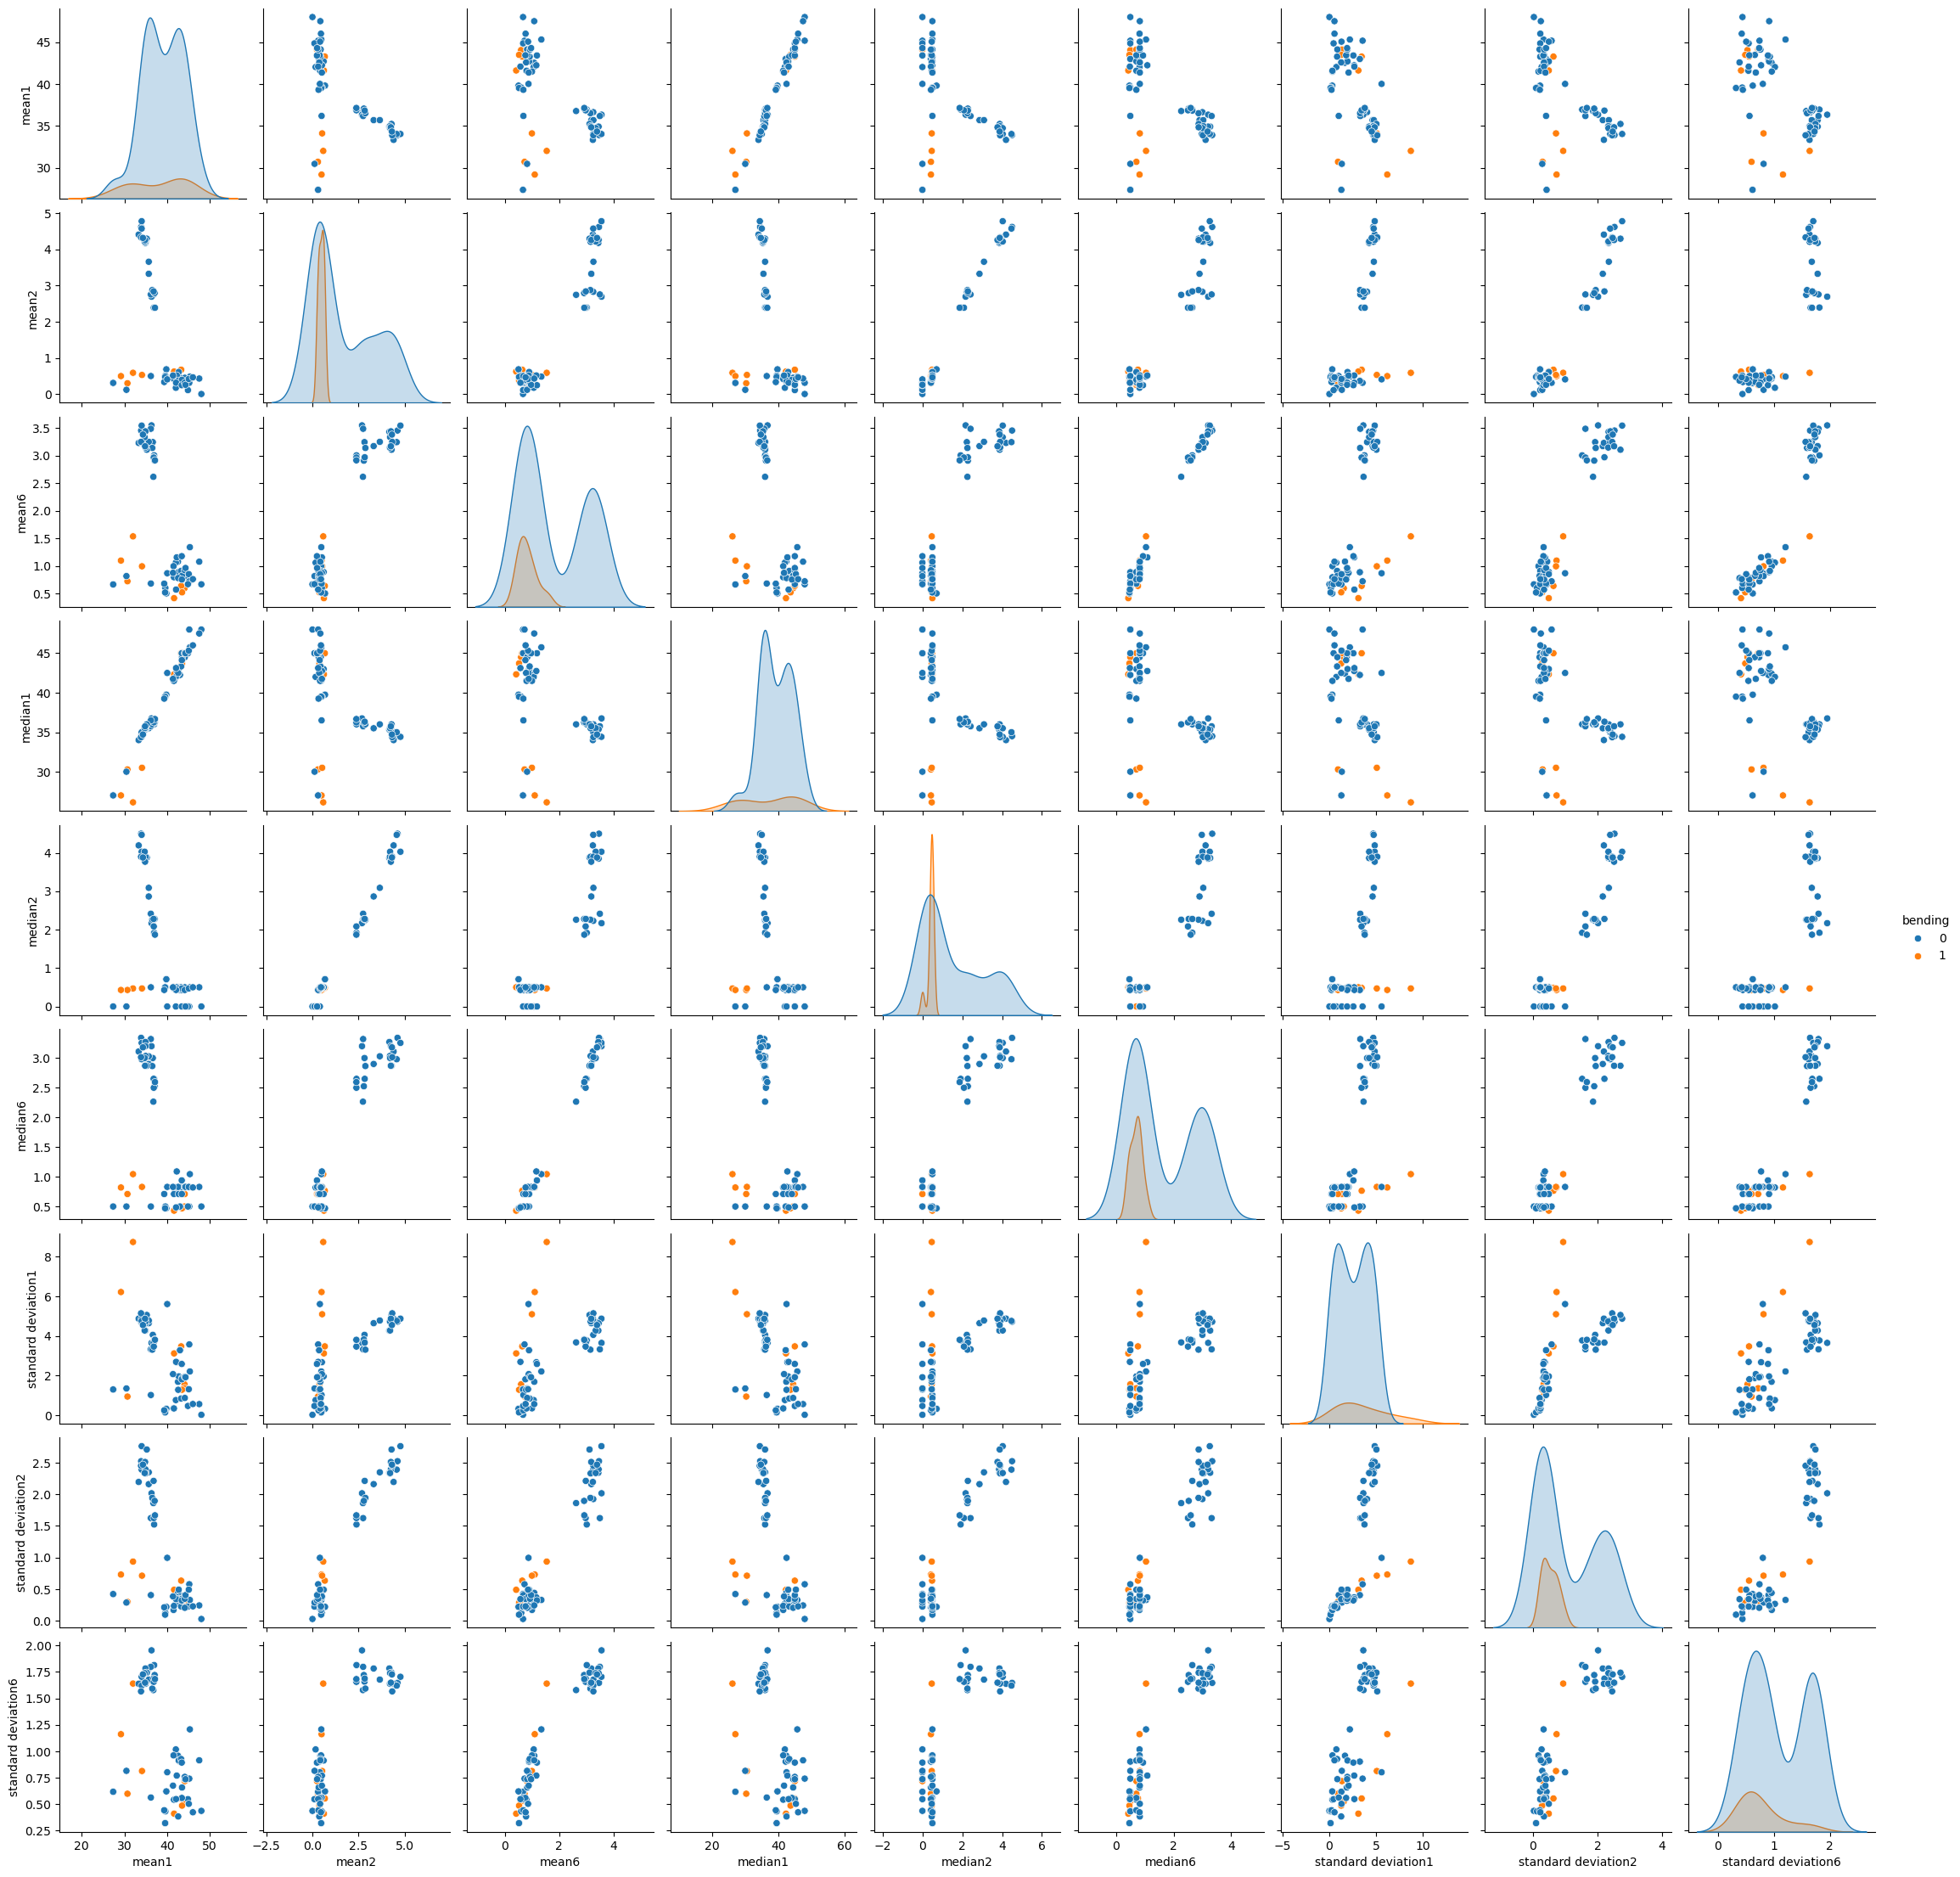

In [11]:
# add the bending column to the first half time seies dataframe for plotting
f1_cols = features_h1.columns.to_list()
f1_cols.append("bending")

plot1_df = features_h1.merge(y_train, left_index=True, right_index=True)[f1_cols]
sns.pairplot(plot1_df, hue="bending")

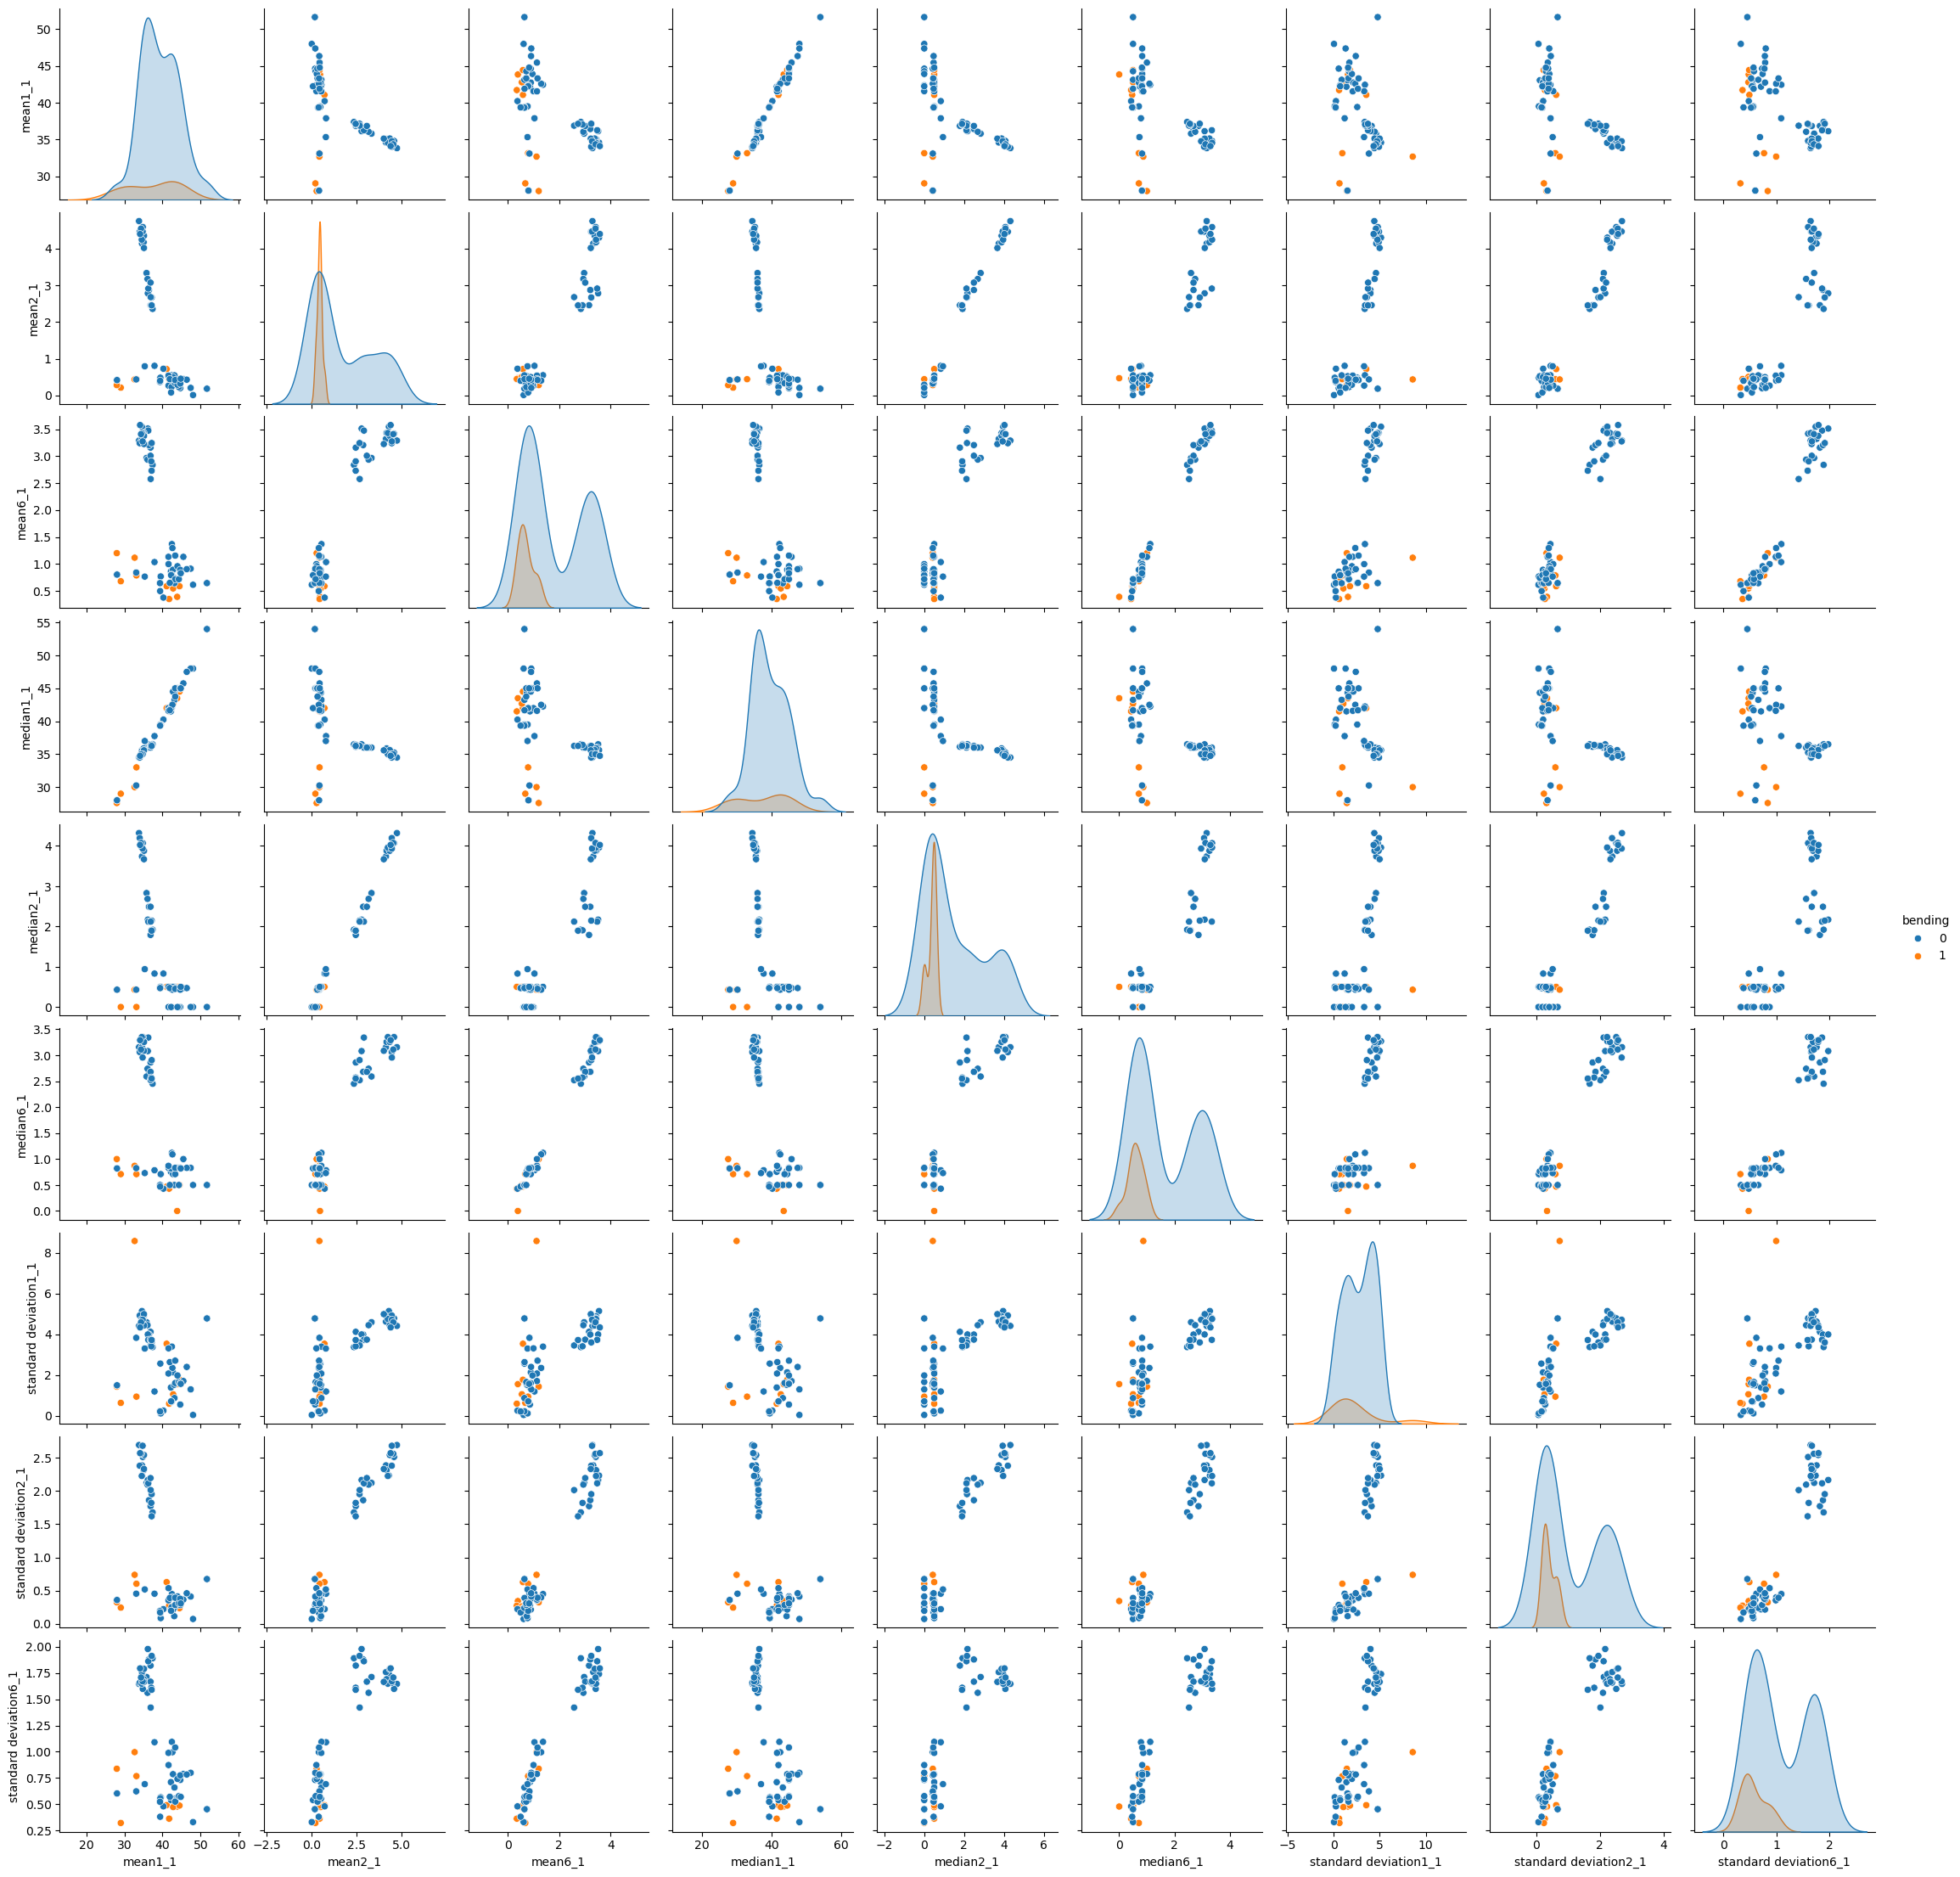

In [12]:
# add the bending column to the second half time seies dataframe for plotting
f2_cols = features_h2.columns.to_list()
f2_cols.append("bending")

plot2_df = features_h2.merge(y_train, left_index=True, right_index=True)[f2_cols]
sns.pairplot(plot2_df, hue="bending")

Difference:
After breaking into two time series, the overlaps of the scatter in the same subplot are less. That is, the boundaries between classes are more clear.


#### iii. Time Series Segments

In [13]:
def data_split(data, l_ls):
    """
    This function is used to split the data into different time series

    parameters:
    data[dataframe]: dataframe to be splitted
    l_ls[list]: the number of time series to be splitted

    returns:
    all_outputs[dict]: the keys are the number of time series and the values are the splitted dataframes
    """
    all_outputs = {}
    for l in l_ls:
        parts = []
        for t in range(l):
            g = data.groupby(level="path", group_keys=False)
            df = g.apply(
                lambda x, t=t, l=l: x.iloc[(t * len(x)) // l : ((t + 1) * len(x)) // l]
            )
            parts.append(df)

        all_outputs[l] = parts
    return all_outputs

In [14]:
def data_combine(df, l_ls):
    """
    this function combines the dataframes in the list l_ls into one dataframe

    parameters:
    df[datafram]: the original dataframe
    l_ls[list]: a list of dataframes

    returns:
    df_com[dict]: the keys are the number of time series and the values are the combined dataframes
    """
    df_new = df.copy()
    df_new.drop(columns=["bending"], inplace=True)
    df_new.set_index(["time", "path"], inplace=True)

    df_dic = data_split(df_new, l_ls)

    df_rename = {}
    for i, df_ls in df_dic.items():
        rename_ls = []
        for j, df in enumerate(df_ls):
            if j == 0:
                rename_ls.append(df)
            else:
                df_n = df.add_suffix("_" + f"{j}")
                rename_ls.append(df_n)
        df_rename[i] = rename_ls

    df_com = {}
    for i, df_ls in df_rename.items():
        out = df_ls[0].join(df_ls[1:], how="outer")
        df_com[i] = out

    return df_com

In [15]:
# get the dictionary for training sets: key is the number of time series, value is the training set for that time series
l_list = list(range(1, 21))
tr_com = data_combine(train_df, l_list)
tr_feat = {}
for i, df in tr_com.items():
    ls = list(range(1, 6 * i + 1))
    tr_feat[i] = extract_features(df, time_series=ls)

In [16]:
# get the dictionary for test sets: key is the number of time series, value is the test set for that time series
te_com = data_combine(test_df, l_list)
te_feat = {}
for i, df in te_com.items():
    ls = list(range(1, 6 * i + 1))
    te_feat[i] = extract_features(df, time_series=ls)

In [17]:
# create an empty dataframe to store the performance
performance = pd.DataFrame(columns=["l", "best_p", "accuracy", "selected_features"])

# model fit
for l, X_train_l in tr_feat.items():
    model = LogisticRegression(C=1e6, solver="lbfgs", class_weight="balanced") 
    selector = RFECV(
        estimator=model,
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        scoring="accuracy",
    )

    res = selector.fit(X_train_l, y_train.iloc[:, 0])

    # get the best number of features, the corresponding accuracy and selcted features
    b_p = res.n_features_
    b_s = res.cv_results_["mean_test_score"][b_p - 1]
    s_f = X_train_l.columns[res.support_].tolist()

    performance.loc[len(performance)] = [l, b_p, b_s, s_f]

per_sorted = performance.sort_values(by=["accuracy", "best_p"], ascending=[False, True])
display(per_sorted)

,l,best_p,accuracy,selected_features
16,17,7,1.000000,"[min29, min95, max5, max67, mean17, 1st quart1..."
17,18,18,1.000000,"[min11, min17, min29, min35, min95, min101, ma..."
15,16,27,1.000000,"[min11, min17, min29, min53, min59, min83, min..."
18,19,4,0.985714,"[min17, min101, max73, 1st quart17]"
12,13,7,0.985714,"[min11, min23, min71, max49, mean11, median11,..."
19,20,13,0.985714,"[min11, min17, min35, min41, min107, max61, ma..."
4,5,15,0.985714,"[min3, min11, max5, max8, max12, max18, mean5,..."
11,12,15,0.985714,"[min11, min23, min65, max5, max31, max37, max4..."
10,11,17,0.985714,"[min11, min23, min41, min59, max5, max31, max4..."
14,15,32,0.985714,"[min11, min17, min29, min53, min77, min83, max..."


The wrong way to perform cross-validation is to apply it only after feature selection.In this case, the information from the entire dataset leaks into the feature selection process, leading overly optimistic performance. Instead, we should use cross validation to both select features and evaluate the performance of the selected features.

#### iv. Confusion Matrix

The confusion matrix for the best model is: 
[[60  0]
 [ 0  9]]
The ROC AUC for the best model is: 1.0


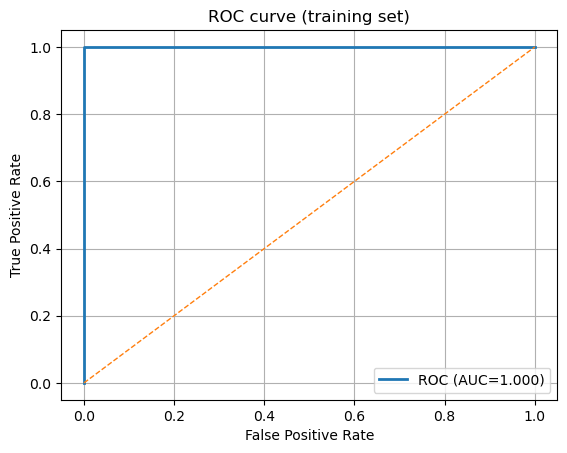

In [18]:
# get the best l and selected features, extract the training set
l_best = per_sorted["l"].iloc[0]
f_best = per_sorted["selected_features"].iloc[0]

tr_best = tr_feat[l_best][f_best]

# fit the logistic regression model on the training set
model = LogisticRegression(C=1e6, solver="lbfgs", class_weight="balanced")
logit_model = model.fit(tr_best, y_train.iloc[:, 0])

y_pred_tr = logit_model.predict(tr_best)
y_prob_tr = logit_model.predict_proba(tr_best)[:, 1]

# calculate the confusion matrix and ROC AUC for the training set
cm_tr = confusion_matrix(y_train.iloc[:, 0], y_pred_tr)
fpr_tr, tpr_tr, _ = roc_curve(y_train.iloc[:, 0], y_prob_tr)
auc_tr = auc(fpr_tr, tpr_tr)

print(f"The confusion matrix for the best model is: \n{cm_tr}")
print(f"The ROC AUC for the best model is: {auc_tr}")

plt.figure()
plt.plot(fpr_tr, tpr_tr, lw=2, label=f"ROC (AUC={auc_tr:.3f})")
plt.plot([0, 1], [0, 1], "--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (training set)")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# get the p-values for selected features
X_sm = sm.add_constant(tr_best)
logit = sm.Logit(y_train, X_sm)
res = logit.fit(method = 'lbfgs')
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:                bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            7
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                   1.000
Time:                        15:22:07   Log-Likelihood:            -2.6407e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 3.041e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0155   7078.920  -2.19e-06      1.000   -1.39e+04    1.39e+04
min29           0.7155    261.545      0.003      0.998    -511.903     513.334
min95           0.6367    153.715      0.004    

#### v. Test Classifier

The accuracy for the best model is: 1.0


The confusion matrix for the best model is: 
[[15  0]
 [ 0  4]]
The ROC AUC for the best model is: 1.0


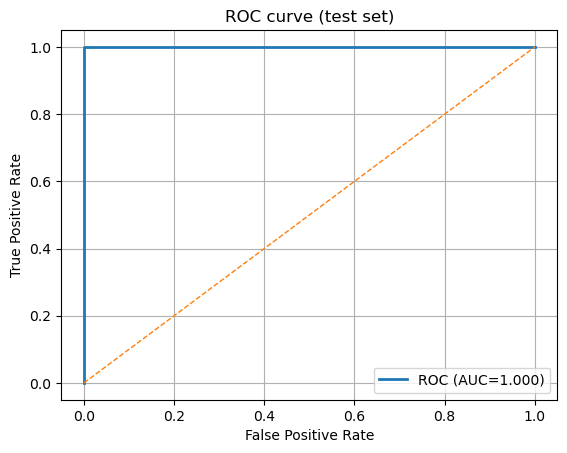

In [20]:
# get the corresponding test set
te_best = te_feat[l_best][f_best]

# test the best model on the test set
y_pred_te = logit_model.predict(te_best)
y_prob_te = logit_model.predict_proba(te_best)[:, 1]

# evaluate the performance of the best model on the test set
acc_te = accuracy_score(y_test.iloc[:, 0], y_pred_te)
cm_te = confusion_matrix(y_test.iloc[:, 0], y_pred_te)
fpr_te, tpr_te, _ = roc_curve(y_test.iloc[:, 0], y_prob_te)
auc_te = auc(fpr_te, tpr_te)

print(f"The accuracy for the best model is: {acc_te}")
print(f"The confusion matrix for the best model is: \n{cm_te}")
print(f"The ROC AUC for the best model is: {auc_te}")

plt.figure()
plt.plot(fpr_te, tpr_te, lw=2, label=f"ROC (AUC={auc_te:.3f})")
plt.plot([0, 1], [0, 1], "--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (test set)")
plt.legend()
plt.grid(True)
plt.show()

#### vi. Separation

Yes, the calsses seem to be well-seperated to cause instability in calculating logit regression. The accuracy scores achieved at 1 and the p-values for coefficients are insignificant, which might refers to the instability of estimations. Meanwhiile, the singular matrix error occurs when I tried to fit the model using statsmodels.logit.Logit.fit() function.

#### vii. Imbalance

From the confusion matrices, we can see that the classes are imblanced. The training set has 60 samples of bending 1 and only 9 samples of bending 0, which is very unbalanced.

The confusion matrix for the best model is: 
[[9 0]
 [0 9]]
The ROC AUC for the best model is: 1.0


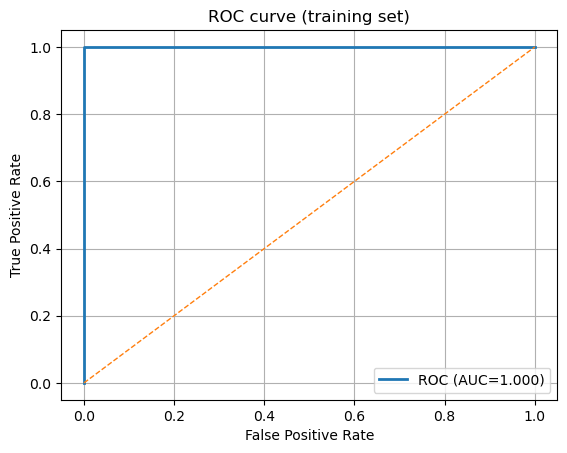

In [21]:
# under sample the majority class to balance the dataset
sample = RandomUnderSampler(sampling_strategy="auto")
X_tr_bal, y_tr_bal = sample.fit_resample(tr_best, y_train.iloc[:, 0])

# fit the model on the balanced dataset again
model = LogisticRegression(C=1e6, solver="lbfgs", class_weight="balanced")
logit_model_bal = model.fit(X_tr_bal, y_tr_bal)

y_pred_bal = logit_model_bal.predict(X_tr_bal)
y_prob_bal = logit_model.predict_proba(X_tr_bal)[:, 1]

cm_bal = confusion_matrix(y_tr_bal, y_pred_bal)
fpr_bal, tpr_bal, _ = roc_curve(y_tr_bal, y_prob_bal)
auc_bal = auc(fpr_bal, tpr_bal)

print(f"The confusion matrix for the best model is: \n{cm_bal}")
print(f"The ROC AUC for the best model is: {auc_bal}")

plt.figure()
plt.plot(fpr_bal, tpr_bal, lw=2, label=f"ROC (AUC={auc_bal:.3f})")
plt.plot([0, 1], [0, 1], "--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (training set)")
plt.legend()
plt.grid(True)
plt.show()

The accuracy for the best model is: 1.0
The confusion matrix for the best model is: 
[[15  0]
 [ 0  4]]
The ROC AUC for the best model is: 1.0


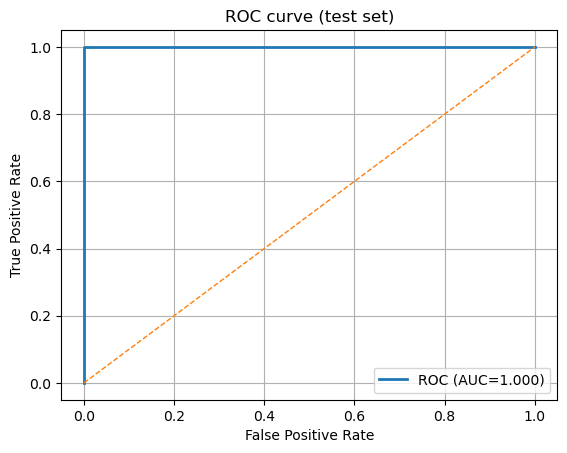

In [22]:
# fit the model on test set
y_pred_te_bal = logit_model_bal.predict(te_best)
y_prob_te_bal = logit_model_bal.predict_proba(te_best)[:, 1]

acc_te_bal = accuracy_score(y_test.iloc[:, 0], y_pred_te_bal)
cm_te_bal = confusion_matrix(y_test.iloc[:, 0], y_pred_te_bal)
fpr_te_bal, tpr_te_bal, _ = roc_curve(y_test.iloc[:, 0], y_prob_te_bal)
auc_te_bal = auc(fpr_te_bal, tpr_te_bal)

print(f"The accuracy for the best model is: {acc_te_bal}")
print(f"The confusion matrix for the best model is: \n{cm_te_bal}")
print(f"The ROC AUC for the best model is: {auc_te_bal}")

plt.figure()
plt.plot(fpr_te_bal, tpr_te_bal, lw=2, label=f"ROC (AUC={auc_te_bal:.3f})")
plt.plot([0, 1], [0, 1], "--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (test set)")
plt.legend()
plt.grid(True)
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [23]:
per_l1 = pd.DataFrame(columns=["l", "best_c", "accuracy", "selected_features"])

# using l1-penalized logistic regression with cross-validation to select features
for l, X_train_l in tr_feat.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    Cs = np.logspace(-2, 4, 10)
    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "classifier",
                LogisticRegressionCV(
                    Cs=Cs,
                    cv=cv,
                    penalty="l1",
                    solver="liblinear",
                    class_weight="balanced",
                    scoring="accuracy",
                ),
            ),
        ]
    )
    pipe.fit(X_train_l, y_train.iloc[:, 0])

    log = pipe.named_steps["classifier"]

    # get the best_c, accuarcy, and selected features
    b_C = log.C_[0]
    b_acc = log.scores_[list(log.scores_.keys())[0]].mean(axis=0).max()

    coef = log.coef_
    f_sel = (np.abs(coef) > 0).any(axis=0)
    selected_features = X_train_l.columns[f_sel].tolist()

    per_l1.loc[len(per_l1)] = [l, b_C, b_acc, selected_features]

per_l1_s = per_l1.sort_values(by=["accuracy", "best_c"], ascending=[False, True])
display(per_l1_s)

,l,best_c,accuracy,selected_features
19,20,21.544347,0.985714,"[min4, min17, min37, min42, min45, min62, min1..."
17,18,1.000000,0.971429,"[min11, min95, min101, max29, max55, mean17, s..."
9,10,21.544347,0.971429,"[min17, min53, min59, max5, max17, max24, max3..."
0,1,464.158883,0.971429,"[min1, min3, min5, max1, max2, max4, max5, mea..."
12,13,1.000000,0.970330,"[min11, min65, min71, max17, max37, max49, max..."
18,19,1.000000,0.970330,"[min11, min17, min101, min107, max61, max79, s..."
16,17,21.544347,0.970330,"[min11, min17, min29, min39, min95, max5, max1..."
3,4,464.158883,0.957143,"[min21, min23, max2, max3, max4, max5, max10, ..."
10,11,0.215443,0.957143,"[min5, min59, max31, median11, median46, stand..."
11,12,0.215443,0.957143,"[min65, max37, max66, 1st quart11]"


#### ii. Comparison

The L1-penalized logistic regression model performs better. There are some accuracy score for the variable selection using p-values achieved exaclty 1, taking high risk of overfitting. Meanwhile, L1-penalized logistic model is more eaiser to implement.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [24]:
# get the classes for each instance to perform multi-class classification
y_tr_multi = y_train.copy()
y_tr_multi["class"] = y_tr_multi.index.map(lambda x: x[0])
y_tr_multi.drop(columns=["bending"], inplace=True)


y_te_multi = y_test.copy()
y_te_multi["class"] = y_te_multi.index.map(lambda x: x[0])
y_te_multi.drop(columns=["bending"], inplace=True)

In [ ]:
per_multi = pd.DataFrame(columns=["l", "best_c", "accuracy", "selected_features"])

# multi-class classification using l1-penalized logistic regression
for l, X_train_l in tr_feat.items():
    cv = StratifiedKFold(n_splits=4, shuffle=True) # the least populated class in y has only 4 members, so we use 4-fold cross-validation
    Cs = np.logspace(-2, 4, 10)
    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "classifier",
                LogisticRegressionCV(
                    Cs=Cs,
                    cv=cv,
                    penalty="l1",
                    solver="saga",
                    multi_class="multinomial",
                    class_weight="balanced",
                    scoring="accuracy",
                    max_iter=5000
                ),
            ),
        ]
    )
    pipe.fit(X_train_l, y_tr_multi.iloc[:, 0])

    # get the best C, accuracy, and selected features
    log = pipe.named_steps["classifier"]

    mean_over_Cs = np.mean([arr.mean(axis=0) for arr in log.scores_.values()], axis=0)
    b_acc = float(mean_over_Cs.max())
    b_C = float(log.C_[0])

    coef = log.coef_
    f_sel = (np.abs(coef) > 1e-9).any(axis=0)
    selected_features = X_train_l.columns[f_sel].tolist()

    per_multi.loc[len(per_multi)] = [l, b_C, b_acc, selected_features]

per_multi_s = per_multi.sort_values(by=["accuracy", "best_c"], ascending=[False, True])
display(per_multi_s)

/Users/hunnechen/anaconda3/envs/workspace/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hunnechen/anaconda3/envs/workspace/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hunnechen/anaconda3/envs/workspace/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hunnechen/anaconda3/envs/workspace/lib/python

,l,best_c,accuracy,selected_features
0,1,1.000000,0.941993,"[min5, max3, max4, max5, median1, median2, sta..."
1,2,4.641589,0.897876,"[min4, min5, min6, min11, min12, max1, max4, m..."
3,4,4.641589,0.885621,"[min4, min6, min8, min11, min14, min15, min17,..."
5,6,21.544347,0.843137,"[min1, min2, min3, min4, min5, min6, min7, min..."
6,7,21.544347,0.841503,"[min1, min3, min4, min5, min6, min7, min9, min..."
4,5,1.000000,0.840686,"[min3, min4, min5, min11, min14, min18, min23,..."
14,15,100.000000,0.839869,"[min1, min2, min3, min4, min5, min6, min7, min..."
2,3,100.000000,0.825163,"[min1, min2, min3, min4, min5, min6, min7, min..."
13,14,21.544347,0.813725,"[min1, min2, min3, min4, min5, min6, min7, min..."
16,17,21.544347,0.812092,"[min1, min2, min3, min4, min5, min6, min7, min..."


/Users/hunnechen/anaconda3/envs/workspace/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


test error:0.10526315789473684


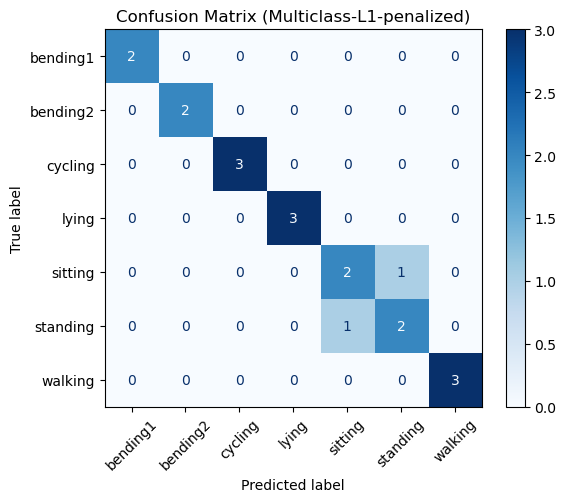

In [32]:
# map class labels and the number
class_labels = {k:v for v, k in folder_path_dic.items()}

# get the training and test sets
l_l1 = per_multi_s["l"].iloc[0]
c_l1 = per_multi_s["best_c"].iloc[0] 
f_l1 = per_multi_s["selected_features"].iloc[0]

tr_l1 = tr_feat[l_l1][f_l1]
te_l1 = te_feat[l_l1][f_l1]

# fit l1-penalized logistic regression model on selected training set
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "classifier",
            LogisticRegression(
                C=c_l1,
                penalty="l1",
                solver="saga",
                multi_class="multinomial",
                class_weight="balanced",
                max_iter=4000,
            ),
        ),
    ]
)
pipe.fit(tr_l1, y_tr_multi.iloc[:, 0])

# predict on test set and calculate test error
y_pred = pipe.predict(te_l1)
test_acc = accuracy_score(y_te_multi.iloc[:, 0], y_pred)
test_error = 1 - test_acc

print(f"test error:{test_error}")


# calculate confusion matrix and plot it
label_num = y_te_multi.iloc[:, 0].unique()
cm = confusion_matrix(y_te_multi.iloc[:, 0], y_pred, labels=label_num)
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels.values()).plot(
    ax=ax, cmap="Blues", xticks_rotation=45,colorbar=True
)
ax.set_title("Confusion Matrix (Multiclass-L1-penalized)")
plt.tight_layout()
plt.show()

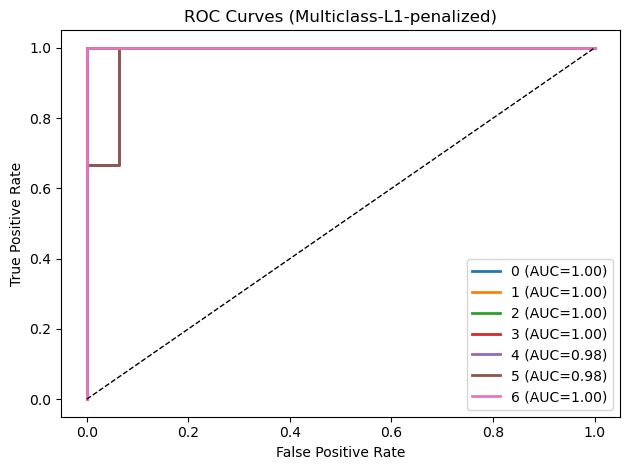

In [27]:
# calculate ROC curves and plot them
y_score = pipe.predict_proba(te_l1)
y_bin = label_binarize(y_te_multi.values, classes=label_num)

fpr = {}
tpr = {}
roc_auc = {}
for i, cls in enumerate(label_num):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, cls in enumerate(label_num):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{cls} (AUC={roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Multiclass-L1-penalized)")
plt.legend()
plt.tight_layout()
plt.show()


#### ii. Naive Bayes

In [28]:
# multi-class classification using Gaussian Naive Bayes
accurs = []
for l, X_train_l in tr_feat.items():
    
    cv = StratifiedKFold(n_splits=4, shuffle=True)
    scores = cross_val_score(GaussianNB(), X_train_l, y_tr_multi.iloc[:, 0], cv=cv, scoring="accuracy")
    accur = float(scores.mean())
    accurs.append({"l": l, "accuracy": accur})

per_gauss = pd.DataFrame(accurs).sort_values(by="accuracy", ascending=False)
display(per_gauss)

,l,accuracy
1,2,0.857026
0,1,0.767157
9,10,0.726307
3,4,0.711601
2,3,0.696078
6,7,0.682190
12,13,0.667484
7,8,0.667484
4,5,0.666667
11,12,0.666667


test error: 0.368421052631579


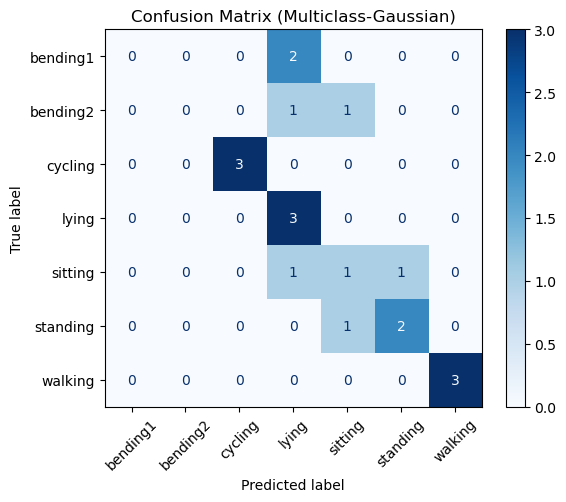

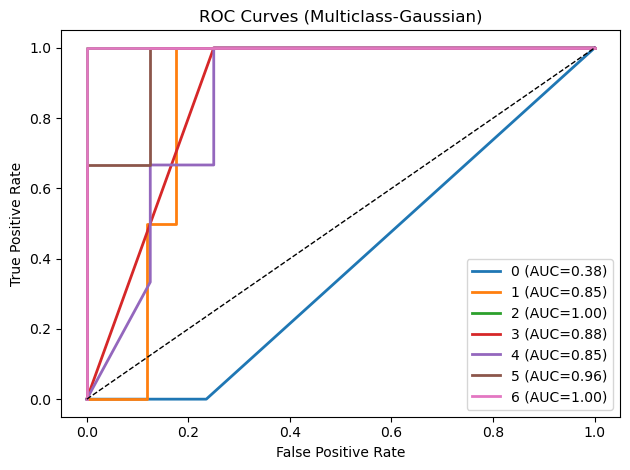

In [29]:
# get the training and test sets for best l
l_gauss = per_gauss["l"].iloc[0]
tr_gauss = tr_feat[l_gauss]
te_gauss = te_feat[l_gauss]

# fit a Gaussian Naive Bayes model on the training set
m_gauss = GaussianNB()
m_gauss.fit(tr_gauss, y_tr_multi.iloc[:, 0])

# predict on the test set 
y_pred = m_gauss.predict(te_gauss)
test_acc  = accuracy_score(y_te_multi.iloc[:, 0], y_pred)
test_err  = 1.0 - test_acc
print(f"test error: {test_err}")

# calculate confusion matrix and plot it
label_num = y_te_multi.iloc[:, 0].unique()
cm = confusion_matrix(y_te_multi.iloc[:, 0], y_pred, labels=y_te_multi.iloc[:, 0].unique())
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels.values()).plot(
    ax=ax, cmap="Blues", xticks_rotation=45,colorbar=True
)
ax.set_title("Confusion Matrix (Multiclass-Gaussian)")
plt.tight_layout()
plt.show()

# calculate ROC curves and plot them
y_score = m_gauss.predict_proba(te_gauss)
y_bin = label_binarize(y_te_multi.iloc[:, 0], classes=label_num)
fpr = {}
tpr = {}
roc_auc = {}
for i, cls in enumerate(label_num):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, cls in enumerate(label_num):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{cls} (AUC={roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Multiclass-Gaussian)")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# multi-class classification using Multinomial Naive Bayes
accurs = []
for l, X_train_l in tr_feat.items():
    
    cv = StratifiedKFold(n_splits=4, shuffle=True)
    scores = cross_val_score(MultinomialNB(), X_train_l, y_tr_multi.iloc[:, 0], cv=cv, scoring="accuracy")
    accur = float(scores.mean())
    accurs.append({"l": l, "accuracy": accur})

per_mo = pd.DataFrame(accurs).sort_values(by="accuracy", ascending=False)
display(per_mo)

,l,accuracy
4,5,0.853758
7,8,0.840686
2,3,0.825163
6,7,0.824346
3,4,0.823529
11,12,0.811275
5,6,0.797386
14,15,0.797386
9,10,0.796569
0,1,0.783497


test error: 0.26315789473684215


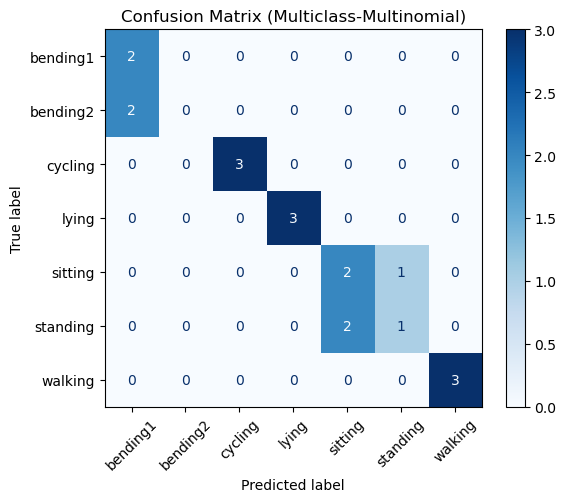

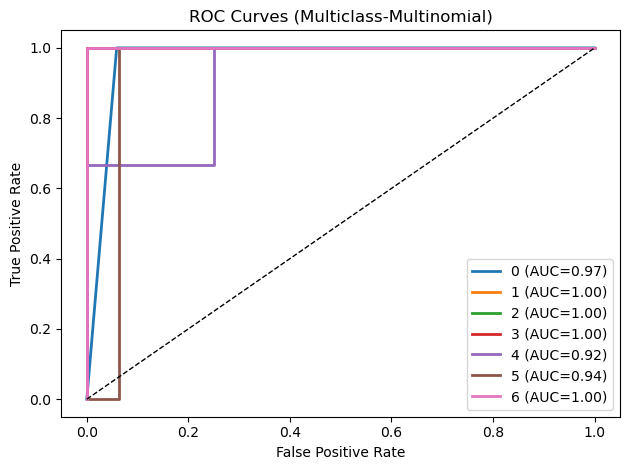

In [31]:
# get the training and test sets for best l
l_mo = per_mo["l"].iloc[0]
tr_mo = tr_feat[l_mo]
te_mo = te_feat[l_mo]

# fit a Multinomial Naive Bayes model on the training set
m_mo = MultinomialNB()
m_mo.fit(tr_mo, y_tr_multi.iloc[:, 0])

# predict on the test set 
y_pred = m_mo.predict(te_mo)
test_acc  = accuracy_score(y_te_multi.iloc[:, 0], y_pred)
test_err  = 1.0 - test_acc
print(f"test error: {test_err}")

# calculate confusion matrix and plot it
label_num = y_te_multi.iloc[:, 0].unique()
cm = confusion_matrix(y_te_multi.iloc[:, 0], y_pred, labels=y_te_multi.iloc[:, 0].unique())
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels.values()).plot(
    ax=ax, cmap="Blues", xticks_rotation=45,colorbar=True
)
ax.set_title("Confusion Matrix (Multiclass-Multinomial)")
plt.tight_layout()
plt.show()

# calculate ROC curves and plot them
y_score = m_mo.predict_proba(te_mo)
y_bin = label_binarize(y_te_multi.iloc[:, 0], classes=label_num)
fpr = {}
tpr = {}
roc_auc = {}
for i, cls in enumerate(label_num):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, cls in enumerate(label_num):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{cls} (AUC={roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Multiclass-Multinomial)")
plt.legend()
plt.tight_layout()
plt.show()

#### ii. Comparison

In this problem, the L1-penalized logistic regression model performs better in multi-class classification, which has lowest test errors and the best AUC among three models.

## 3. ISLR 4.8.3

Assuming that $ f_{k}(x)$ is normal, in the one dimensional setting, the normal density takes the form
$$ f_{k}(x) = \frac {1} {\sqrt {2\pi\sigma_k^2}} exp({-\frac{(x-\mu_{k})^2} {2\sigma_{k}^2}}) $$
 where $\mu_{k}$ and $\sigma_{k}^2$ are the mean and variance of the $k$-th normal distribution.

Plugging the $ f_{k}(x)$ into the Bayes' theorem, we get:

$$ p_k(x) =\frac{\pi_k \, \frac{1}{\sqrt{2\pi\sigma_k^2}} \exp\!\left(-\frac{1}{2\sigma_k^2}(x - \mu_k)^2\right)}{\sum_{l=1}^{K} \pi_l \, \frac{1}{\sqrt{2\pi\sigma_l^2}} \exp\!\left(-\frac{1}{2\sigma_l^2}(x - \mu_l)^2\right)} $$

Take the log of the above equation:

$$ \log (p_k(x)) = \log \pi_k - \log (\sqrt{2\pi\sigma_k^2})-\frac{1}{2\sigma_k^2}(x - \mu_k)^2 - \log \sum_{l=1}^{K} \pi_l \, \frac{1}{\sqrt{2\pi\sigma_l^2}} \exp\!\left(-\frac{1}{2\sigma_l^2}(x - \mu_l)^2\right) $$

We want to maximize this equation to assign X=x to the k_th class, that is we want to maximize the equation(remaining the k-related terms):
\begin{align}
\delta_k(x) = \log \pi_k - \frac{1}{2}\log (2\pi\sigma_k^2)-\frac{1}{2\sigma_k^2}(x - \mu_k)^2
&= -\frac{1}{2\sigma_k^2}x^2 +\frac{\mu_k}{\sigma_k^2}x -\frac{\mu_k^2}{2\sigma_k^2} -\tfrac12\log(2\pi\sigma_k^2) +\log\pi_k
\end{align}

Therefore, the Bayes classidier is not linear but quardratic.






## 4. ISLR 4.8.7

Bayes theorem:
$$Pr(Y=k \mid X=x)= \frac {Pr(X=x \mid Y=k) * Pr(Y=k)}{Pr(X=x)}$$

In this case:
\begin{align}
Pr(Yes \mid 4) &= \frac{ Pr(4 \mid Yes)*Pr(Yes)}{Pr(4)}\\
&=\frac{Pr(4 \mid Yes)*Pr(Yes)}{Pr(4 \mid Yes)+Pr(4 \mid No)}
\end{align}

Because $X\sim \mathcal{N}(\mu,\sigma^2)$, ${\mu}_{yes} = 10$, ${\mu}_{no} = 0$, ${\sigma^2}_{yes}={\sigma^2}_{no} = 36$

The prior probability of Yes is 0.8, and the probability of No is 0.2. Therefore,
$$Pr(Yes \mid 4) = \frac{0.8 * exp(\frac{-(4-10)^2}{72})}{0.8 * exp(\frac{-(4-10)^2}{72})+0.2*exp(\frac{-(4-0)^2}{72})}\approx0.752$$

To sum up, the probability that a company will issue a dividend this year given that its percentage profit was 4 last year is about 75%.


## Reference
1. RFECV: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
2. K-Fold cross validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
3. The wrong way and the right way to do cross-validation: https://www.youtube.com/watch?v=jgoa28FR__Y
4. RandomUnderSample: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
5. calculate p values with sklearn: https://github.com/cjlin1/liblinear
6. LogisticRegressionCV: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
7. GaussianNB: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
8. Naive Bayes with cross-validation: https://chiraglakshmipathi.medium.com/a-deep-dive-na%C3%AFve-bayes-classifier-and-k-fold-cross-validation-d9fe179ffd76
8. MultinomialNB: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html